# <center>Sheet 2</center>
# <center>Jacobi and Gauss-Seidel Sparse Solvers</center>

### Functions `abs_resnorm` and `rel_resnorm`
$$[r] = abs\_resnorm\;(A, \hat{x}, b)$$
$$[r] = rel\_resnorm\;(A, \hat{x}, b)$$
<u>Input</u>: $A$ is an $n \times n$ sparse matrix, $\hat{x}$, $b$ are vectors of size $n$. <br>
<u>Output</u>: scalar $r$, with:
$$r_{abs} = \| A \hat{x} - b \|_1\qquad\qquad r_{rel} = \frac{\| A \hat{x} - b \|_1}{\| A \|_1 \| \hat{x} \|_1}$$

Remark:  Use these functions to compute the absolute and relative residual norms of an approximate solution.

In [1]:
import pandas as pd


def abs_resnorm(A, x_hat, b):
    # check input parameters
    if not sp.sparse.issparse(A):
        raise TypeError("Matrix A must be sparse")
    
    if not all(isinstance(param, np.ndarray) for param in [x_hat, b]):
        raise TypeError("x_hat and b must be numpy arrays")
    
    if A.ndim != 2 and A.shape[0] != A.shape[1]:
        raise ValueError("Matrix A must be square")
    
    if x_hat.ndim != 1 or b.ndim != 1:
        raise ValueError("Vectors x_hat and b must be 1D arrays")
    
    # compute the absolute residual norm
    r = np.linalg.norm(A.dot(x_hat) - b, ord = 1)
    return r

In [2]:
def rel_resnorm(A, x_hat, b):
    # raise a warning if the 1-norm of x_hat is zero
    if np.linalg.norm(x_hat, ord = 1) == 0:
        warnings.warn("Division by zero in function rel_resnorm. The 1-norm of x_hat is zero.")
        return np.nan

    # compute the relative residual norm
    r = abs_resnorm(A, x_hat, b) / (sp.sparse.linalg.norm(A, ord = 1) * np.linalg.norm(x_hat, ord = 1))
    return r

# Jacobi method and Gauss-Seidel method <u></u>
Implement the Jacobi method and the Gauss-Seidel method and experimentally investigate the convergence behavior with three given test problems. Show the convergence histories (norm of absolute/relative residual vs. iteration number) graphically.

-  Implement Jacobi and Gauss-Seidel efficiently (you are not allowed to use public implementations available online!). In particular, store the sparse matrix  in a <u>sparse matrix format!</u> <u></u>
- Test matrices: Use the following test matrices from the [Matrix Market](http://math.nist.gov/MatrixMarket/}{http://math.nist.gov/MatrixMarket/) for your experiments:
    - [JPWH_991](https://math.nist.gov/pub/MatrixMarket2/Harwell-Boeing/cirphys/jpwh_991.html)
    - [RDB450](https://math.nist.gov/MatrixMarket/data/NEP/brussel/rdb450.html)
    - [NOS5](https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/lanpro/nos5.html)
<u></u>
- To import MatrixMarket format (`.mtx`) files into Python and convert them into `numpy` arrays, the following code uses the functions `scipy.io.mmread` and `.toarray()`.
- The returned matrix array holds the matrices in <u>**dense**</u> representation. You must convert them into a <u>**sparse**</u> Scipy format!

In [3]:
# We wrote this to download and decompress the matrices automatically.
import gzip
from os.path import exists
from pathlib import Path
import requests
import scipy as sp
import numpy as np
import warnings
import matplotlib.pyplot as plt

def decompress_gz(source: Path, destination: Path = Path("./"), block_size=65536):
    destination = Path(destination, ".".join(str(source).split(".")[:-1]))
    # check if the file exists
    if exists(destination):
        warnings.warn(f"The file {destination} already exists.")
        return destination
    with gzip.open(source, 'rb') as s_file, open(destination, 'wb') as d_file:
        while True:
            block = s_file.read(block_size)
            if not block:
                break
            else:
                d_file.write(block)
    return destination


def download_and_save(source: Path, destination: Path = Path("./")) -> Path:
    # extract the file name form the url, e.g.: filename.zip form `https:random_website.com/sub_path_0/filename.zip`
    destination = Path(destination, str(source).split("/")[-1])
    # check if the file exists
    if exists(destination):
        warnings.warn(f"The file {destination} already exists.")
        return destination
    # download the content from the url
    r = requests.get(source, allow_redirects=True)
    # write the content in the destination file
    open(destination, 'wb').write(r.content)
    return destination


links = ["https://math.nist.gov/pub/MatrixMarket2/Harwell-Boeing/cirphys/jpwh_991.mtx.gz",
         "https://math.nist.gov/pub/MatrixMarket2/NEP/brussel/rdb450.mtx.gz",
         "https://math.nist.gov/pub/MatrixMarket2/Harwell-Boeing/lanpro/nos5.mtx.gz"]

matrices = [sp.io.mmread(decompress_gz(download_and_save(matrix_url))).toarray() for matrix_url in links]

C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\2314417190.py:32: UserWarning: The file jpwh_991.mtx.gz already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\2314417190.py:15: UserWarning: The file jpwh_991.mtx already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\2314417190.py:32: UserWarning: The file rdb450.mtx.gz already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\2314417190.py:15: UserWarning: The file rdb450.mtx already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\2314417190.py:32: UserWarning: The file nos5.mtx.gz already exists.
  warnings.warn(f"The file {destination} already exists.")
C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\2314417190.py:15: UserWarning: The file nos5.mtx alre

In [4]:
# converting all our test matrices into sparse ones, for improved performance
matrix_list = [sp.sparse.csr_matrix(matrix) for matrix in matrices]


Create two functions `jacobi` and `gauss_seidel` of the following forms:
$$[x, iterations, abs\_res\_vec, rel\_res\_vec] = jacobi(A, b, tol, maxit, x_0)$$
$$[x, iterations, abs\_res\_vec, rel\_res\_vec] = gauss\_seidel(A, b, tol, maxit, x_0)$$

<u>Input</u>:
 - Sparse Matrix $A$ of size $ n \times n  $.
 - Vector $b$ of size $n \times 1 $.
 - Scalar $tol$.
 - Integer $maxit$. <br>
 - Vector $x_0$ of size $n \times 1 $.
 

<u>Output</u>: 
 - Vector $x$ of size $n \times 1 $.
 - Integer $iterations$.
 - Vector $abs\_res\_vec$ of size $iterations \times 1$. <br>
 - Vector $rel\_res\_vec$ of size $iterations \times 1$. <br>
 
Remark: 
- The parameter $tol$  denotes the largest admissible relative residual norm $ r $.  <br>
- The iteration is terminated either when the residual drops below $tol$, or when the number of iterations exceeds a specified number $maxit$. The initial guess is supplied via the vector $x_0$.  <br>
- The list of return values contains the solution vector $x$, the number of iterations performed denoted by $ iterations $, and the residual history in $abs\_res\_vec$ and $rel\_res\_vec$, where $abs\_res\_vec(i-1)$ and $rel\_res\_vec(i-1)$ contain the absolute resp. relative residual norm after iteration $ i $. Note that the initial residual norm $\|b-Ax_0\|$ resp. $\|b-Ax_0\|/(\|A\|\|x_0\|)$ is not stored in these arrays.

### Efficiency
For effiency, you have to exploit the sparsity of the input matrix $A$. Do NOT treat $A$ as a dense matrix by iterating over each entry in each iteration (i.e., also the zero entries). This would correspond to inefficient component-wise computation, e.g., for Jacobi in iteration $k$: $\quad x_i^{(k+1)} = \left( b_i - \sum_{j \neq i} a_{ij}\,x_j^{(k)} \right)/a_{ii}, \quad i=1,\dots ,n$, and is therefore NOT allowed!

Instead, exploit the sparsity of $A$ by implementing the matrix form of the algorithms. This results in the following computations in each iteration $k$.
\begin{align}
\text{Jacobi: }\qquad x^{(k+1)}&=D^{−1}(b−(L+U)x^{(k)}) \\
\text{Gauss-Seidel: }\qquad x^{(k+1)} &= (D+L)^{-1} ( b - U x^{(k)} )
\end{align}

In [5]:
# extract diagonal, lower and upper matrices out of input matrix
def dissect_matrix(A):
    D = sp.sparse.diags(1.0 / A.diagonal())
    L = sp.sparse.tril(A, -1)
    U = sp.sparse.triu(A,1)
    N = L + U
    return D, N

In [6]:
x = np.arange(9).reshape((3,3))
x[0,0]=1
x

array([[1, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [7]:
d, n = dissect_matrix(x)
print(d)
print(n)

  (0, 0)	1.0
  (1, 1)	0.25
  (2, 2)	0.125
  (0, 1)	1
  (0, 2)	2
  (1, 0)	3
  (1, 2)	5
  (2, 0)	6
  (2, 1)	7


In [8]:
# slides 25 for iterative splitting A -> M = D and N = -(L + U) 
def jacobi(A, b, tol, maxit, x0):
    # TODO: Write your implementation of the function
    if not isinstance(A, sp.sparse.csr_matrix):
        raise TypeError("Input Matrix A must be a sparse csr matrix!")
    if not isinstance(b, np.ndarray) or not isinstance(x0, np.ndarray):
        raise TypeError("b, and initial x must be numpy arrays!")
    if A.dtype not in [np.float32, np.float64] or b.dtype not in [np.float32, np.float64] or x0.dtype not in [np.float32, np.float64]:
        raise TypeError("Components in A, b, and initial x must be float!")
    if A.shape[0] != A.shape[1]:
        raise ValueError("A has to be a square matrix!")
    if A.shape[0] != b.shape[0] or A.shape[0] != x0.shape[0]:
        raise ValueError("The dimensions of A, b, and initial x have to match!")
    if not isinstance(tol, float):
        raise TypeError("tol must be float!")
    if not isinstance(maxit, int):
        raise TypeError("maxit must be int!")
    
    M, N = dissect_matrix(A)
    
    x = x0.copy()
    abs_res_list = []
    rel_res_list = []
    rel_res = float('inf')
    iterations = 0
    
    while iterations < maxit:

        if rel_res < tol:
            break
        
        # N@x uses full set of components in x from previous iteration
        x = M @ (b-N@x)
        
        rel_res = rel_resnorm(A, x, b)
        rel_res_list.append(rel_res)
        abs_res_list.append(abs_resnorm(A, x, b))
        
        iterations += 1
    
    abs_res_vec = np.array(abs_res_list)
    rel_res_vec = np.array(rel_res_list)
    
    return x, iterations, abs_res_vec, rel_res_vec


In [9]:
def gauss_seidel(A, b, tol, maxit, x0):
    # TODO: Write your implementation of the function

    # type checks here !
    if not isinstance(A, sp.sparse.csr_matrix):
        raise TypeError("Input Matrix A must be a sparse csr matrix!")
    if not isinstance(b, np.ndarray) or not isinstance(x0, np.ndarray):
        raise TypeError("b, and initial x must be numpy arrays!")
    if A.dtype not in [np.float32, np.float64] or b.dtype not in [np.float32, np.float64] or x0.dtype not in [np.float32, np.float64]:
        raise TypeError("Components in A, b, and initial x must be float!")
    if A.shape[0] != A.shape[1]:
        raise ValueError("A has to be a square matrix!")
    if A.shape[0] != b.shape[0] or A.shape[0] != x0.shape[0]:
        raise ValueError("The dimensions of A, b, and initial x have to match!")
    if not isinstance(tol, float):
        raise TypeError("tol must be float!")
    if not isinstance(maxit, int):
        raise TypeError("maxit must be int!")

    D = sp.sparse.diags(A.diagonal())
    L = sp.sparse.tril(A, -1)
    M = (D + L)
    
    # U is N for splitting in Gauss Seidel
    N = sp.sparse.triu(A,1)
    
    
    x = x0.copy()
    iterations = 0
    abs_res_list = []
    rel_res_list = []
    rel_res = float('inf')

    while rel_res > tol and iterations < maxit:
        
        # by using a solver, we always use the most recent values in x
        # to calculate our new x. 
        # the solver updates the whole x at ones but internally makes use
        # of the aforementioned methodology(D+L is lower triangular matrix
        # and rest is forward substitution)
        rhs = b - N @ x
        x = sp.sparse.linalg.spsolve(D + L, rhs)

        rel_res = rel_resnorm(A, x, b)
        rel_res_list.append(rel_res)
        abs_res_list.append(abs_resnorm(A, x, b))

        iterations += 1

    abs_res_vec = np.array(abs_res_list)
    rel_res_vec = np.array(rel_res_list)

    return x, iterations, abs_res_vec, rel_res_vec

## Convergence behavior

Evaluate the convergence behavior of your implementations of `jacobi` and `gauss_seidel` for the matrices **JPWH_991**, **RDB450** and **NOS5**.

In all test cases, determine the corresponding right hand side $b$ such that the exact solution $x$ of the linear system is a vector of all ones: $x = (1, 1, . . . , 1, 1)^T$.
</u>

Use a tolerance $tol$ of $10^{-6}$ for the **relative** residual norm as convergence criterion.
</u>

For each matrix, plot the residual norm history (i.e., the iterations on the x-axis, the residual norm corresponding to the respective iteration on the y-axis). <u>When plotting residual norms, always use a **logarithmic scale** along the **y-axis**!</u>

Generate the following plots for the three test matrices:

- Absolute residual norm vs. iterations: One figure for each matrix using the `jacobi` method.
- Absolute residual norm vs. iterations: One figure for each matrix using the `gauss_seidel` method.
- Relative residual norm vs. iterations: One figure for each matrix using the `jacobi` method.
- Relative residual norm vs. iterations: One figure for each matrix using the `gauss_seidel` method.

In [10]:
# TODO: Write your implementation here

exact_solution = [np.ones(matrix.shape[0]) for matrix in matrix_list]
b_list = [matrix @ x for matrix, x in zip(matrix_list, exact_solution)]

genesis_x_list = [np.zeros(matrix.shape[0]) for matrix in matrix_list]
tol = 1e-6
maxit = 1000

resultsJacobi = [jacobi(matrix, b, tol, maxit, x0) for matrix, b, x0 in zip(matrix_list, b_list, genesis_x_list)]
resultsGS = [gauss_seidel(matrix, b, tol, maxit, x0) for matrix, b, x0 in zip(matrix_list, b_list, genesis_x_list)]

In [11]:
def plot_residuals(results, matrix_name, method_name):
    
    _, num_iterations, abs_res_vec, rel_res_vec = results
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharex=True)

    # abs res
    ax[0].plot(range(num_iterations), abs_res_vec, label=f'{matrix_name} - Abs', color='darkorchid')
    ax[0].set_title(f'Absolute Residual Norms {matrix_name} - {method_name}')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Abs Res Norm(log)')
    ax[0].set_yscale('log')
    ax[0].grid(True)

    # rel res
    ax[1].plot(range(num_iterations), rel_res_vec, label=f'{matrix_name} - Rel', color='maroon')
    ax[1].set_title(f'Relative Residual Norms {matrix_name} - {method_name}')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Rel Res Norm(log)')
    ax[1].set_yscale('log')
    ax[1].grid(True)

    plt.legend()
    plt.tight_layout()
    plt.show()

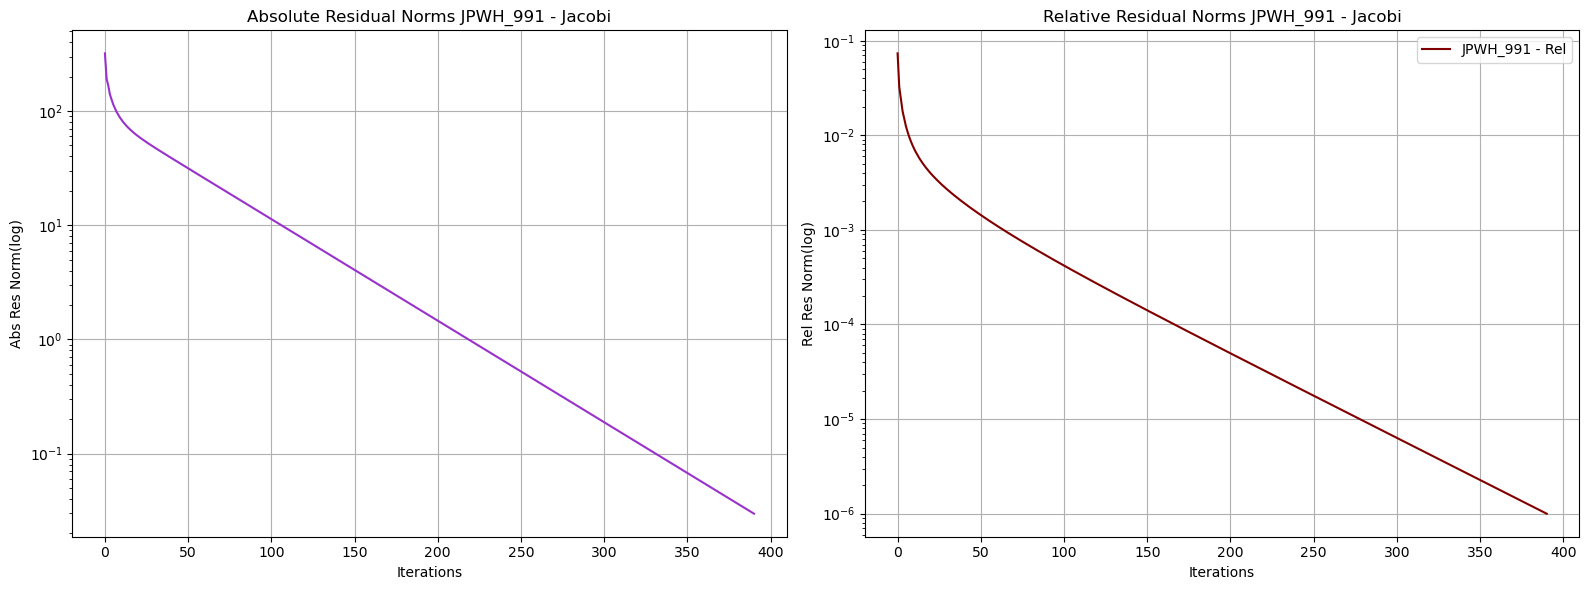

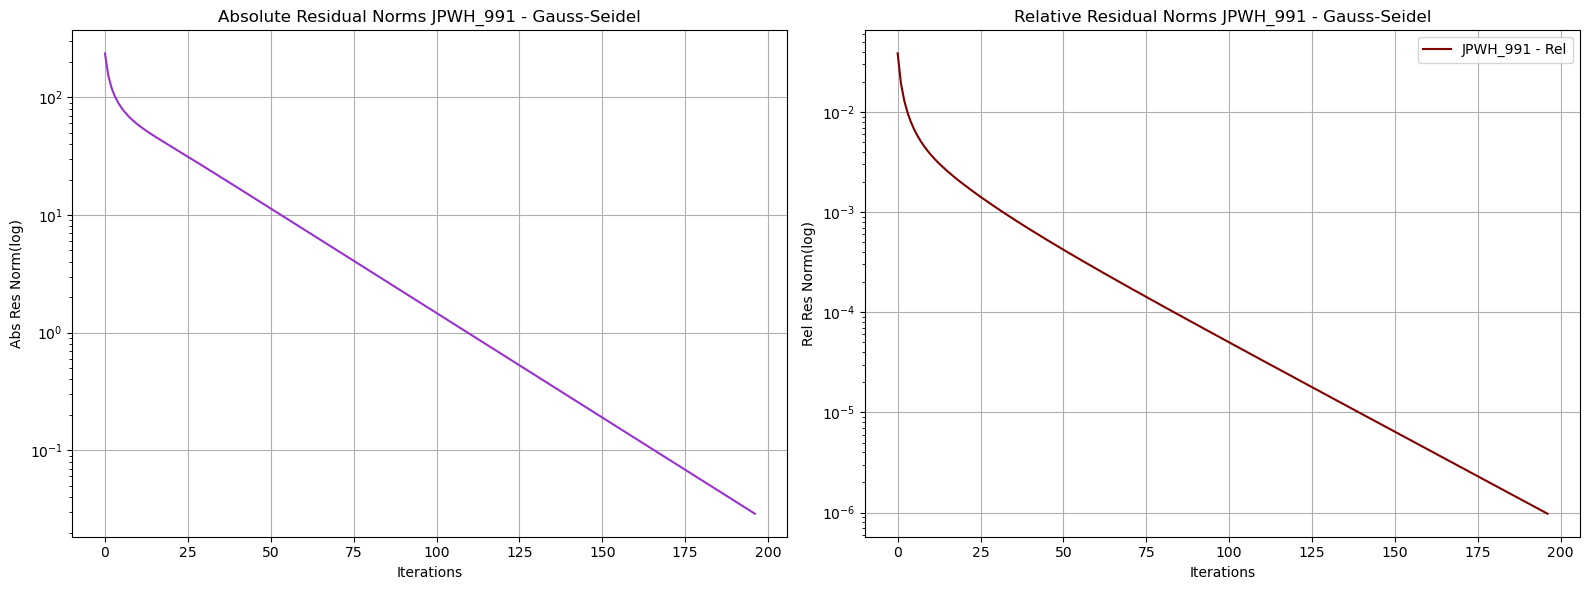

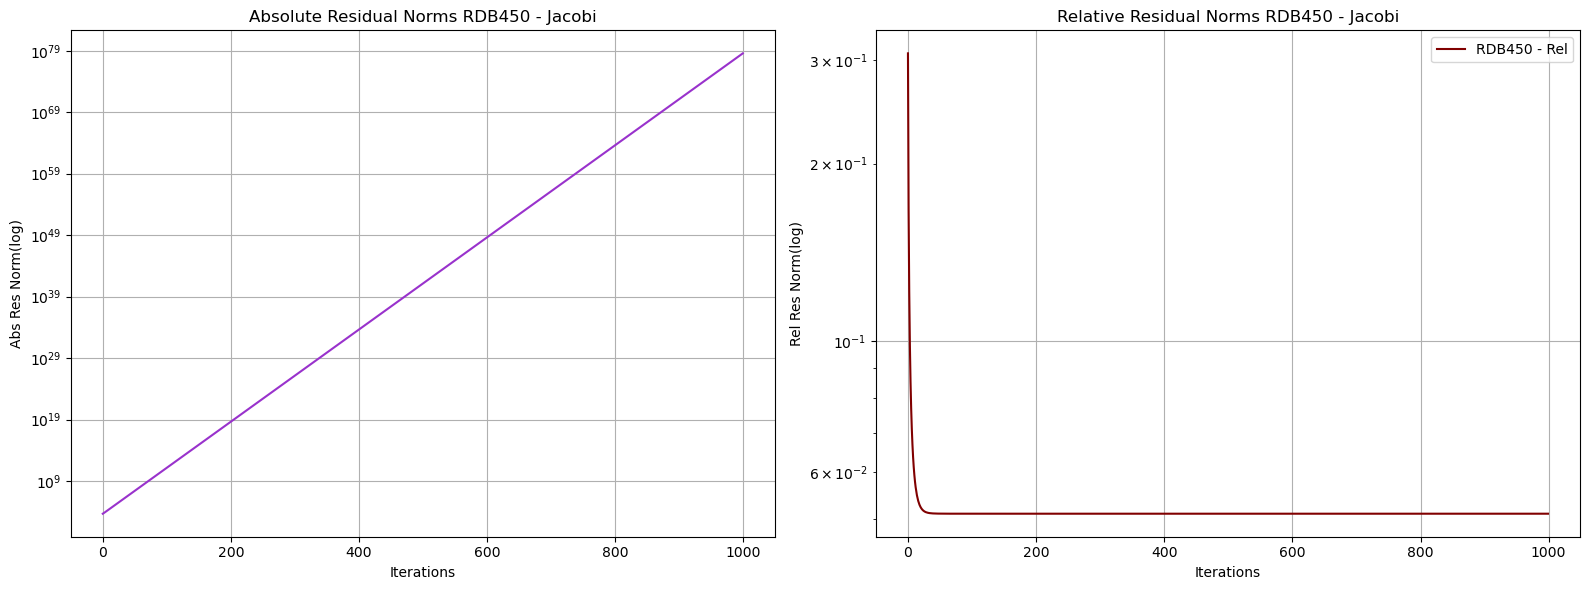

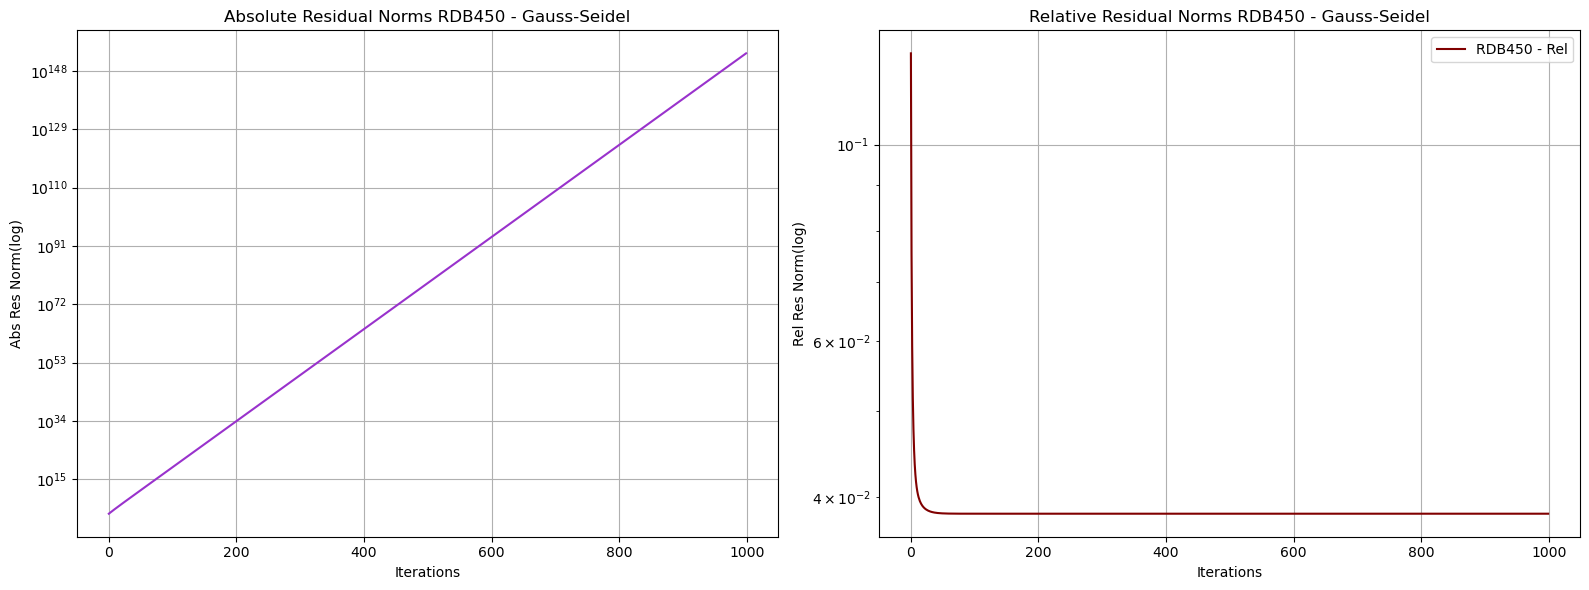

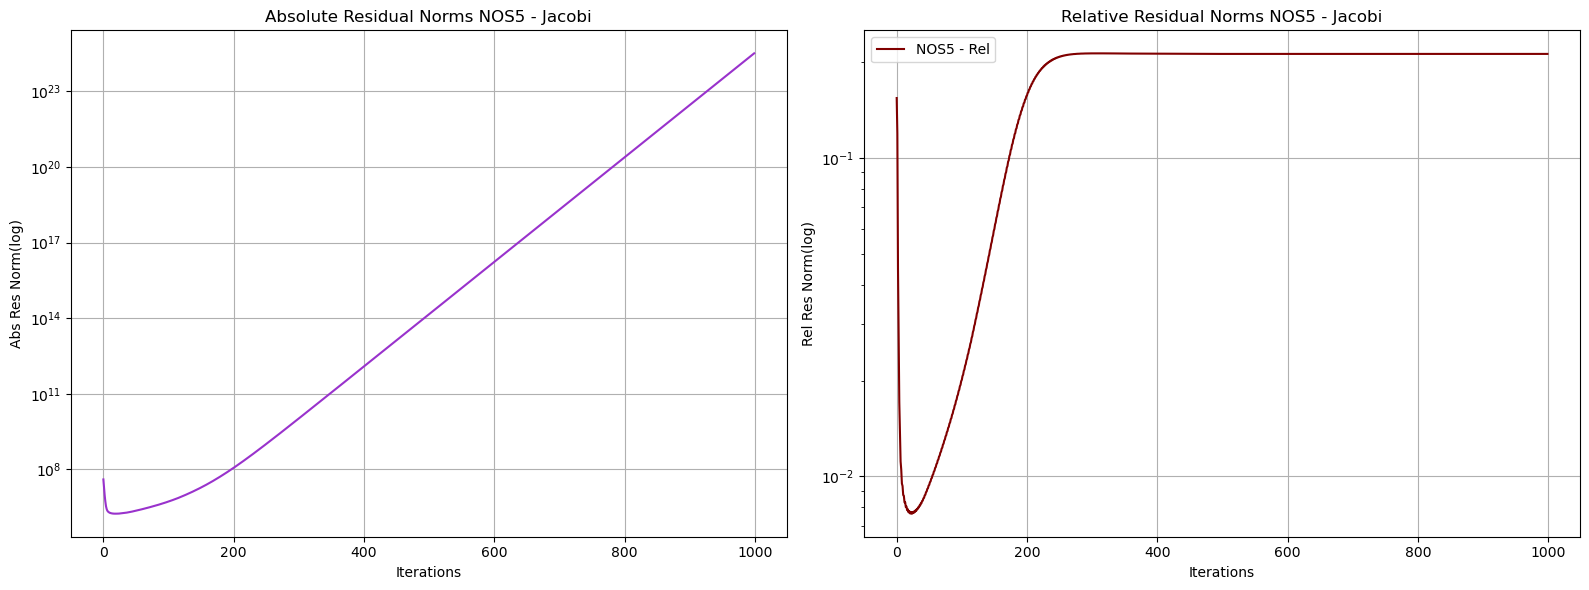

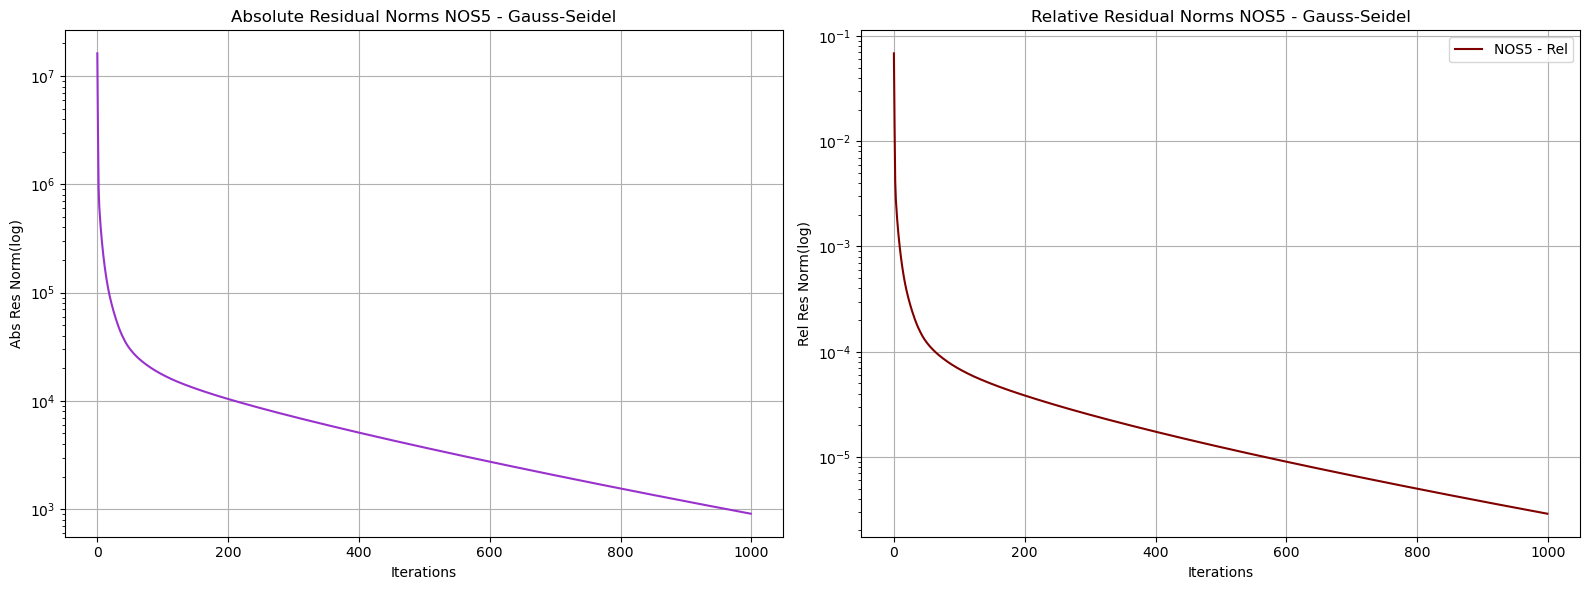

In [12]:
matrix_names = ["JPWH_991", "RDB450", "NOS5"]

for jacobi_result, gs_result, name in zip(resultsJacobi, resultsGS, matrix_names):
    plot_residuals(jacobi_result, name, 'Jacobi')
    plot_residuals(gs_result, name, 'Gauss-Seidel')

In [13]:
print([res[3][-1] for res in resultsJacobi])
print([res[3][-1] for res in resultsGS])

[9.99105818342596e-07, 0.050982396303697504, 0.21199002377250997]
[9.73276853750955e-07, 0.03833062217171472, 2.8881731122911168e-06]


## Reason for convergence respectively divergence

For stationary iterative methods, the iteration matrix $G$ of the iteration scheme $x_{k+1} = Gx_k + c$ determines whether the method will converge or not. For each test matrix and each method, compute the property of $G$ determining the convergence behavior to show why the respective method does or does not converge for the respective matrix.

Hint: For methods using a splitting scheme $A = M - N$, such as `jacobi` and `gauss_seidel`, $G = M^{-1}N$.

### Approach:

We need to find the largest magnitude eigenvalue out of the iteration matrix G(also known as spectral radius) and observe its values.
$$\rho(G) < 1 \; \text{will converge};$$ 
$$\rho(G) \leq 1 \; \text{likely diverges}$$

In [14]:
# TODO: Write your implementation here
def spectral_radius(G):
    eig = sp.sparse.linalg.eigs(G, k=1, which='LM', return_eigenvectors=False)
    spec_rad = np.abs(eig[0])
    return spec_rad

$$G = M^{-1}N$$

### Jacobi G:

$$M := D \; and \; N := -(L+U)$$

$$G_{J} \rightarrow D^{-1} U$$

In [15]:
def get_g_jacobi(A):
    A = A.copy()
    # M
    inverse_d = sp.sparse.diags(1/A.diagonal())
    N = sp.sparse.tril(A, -1) + sp.sparse.triu(A, 1)
    return inverse_d@N

### Gauss Seidel G:

$$M := (D+L)^{-1} \; and \; N := -U$$

$$G_{GS} \rightarrow (D+L)^{-1} U$$

In [16]:
def get_g_gaussseidel(A):
    A = A.copy()
    
    D = sp.sparse.diags(A.diagonal())
    L = sp.sparse.tril(A, -1)
    M = (D + L)

    # U is N for splitting in Gauss Seidel
    N = sp.sparse.triu(A,1)
    return sp.sparse.linalg.spsolve(M, N)

### Evaluate the input matrices

In [17]:
spectral_radii_jac = [spectral_radius(get_g_jacobi(A)) for A in matrix_list]
spectral_radii_gs = [spectral_radius(get_g_gaussseidel(A)) for A in matrix_list]

C:\Users\Merlin\miniconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\Merlin\AppData\Local\Temp\ipykernel_15588\283842683.py:10: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return sp.sparse.linalg.spsolve(M, N)


In [18]:
def plot_radii(resultlists):

    radii_j = resultlists[0]
    radii_gs = resultlists[1]
    
    plt.figure(figsize=(14, 8))
    plt.suptitle('Jacobi vs Gauss-Seidel Method Convergence', fontsize=16, fontweight='bold')
    plt.subplot(1,2,1)
    plt.title('Spectral Radii - Jacobi Method')
    plt.bar(matrix_names, radii_j, color='darkorchid')
    
    plt.ylabel('spectral radius')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1,2,2)
    plt.title('Spectral Radii - Gauss Seidel Method')
    plt.bar(matrix_names, radii_gs, color='maroon')

    plt.xticks(rotation=45, ha='right', fontsize='small')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

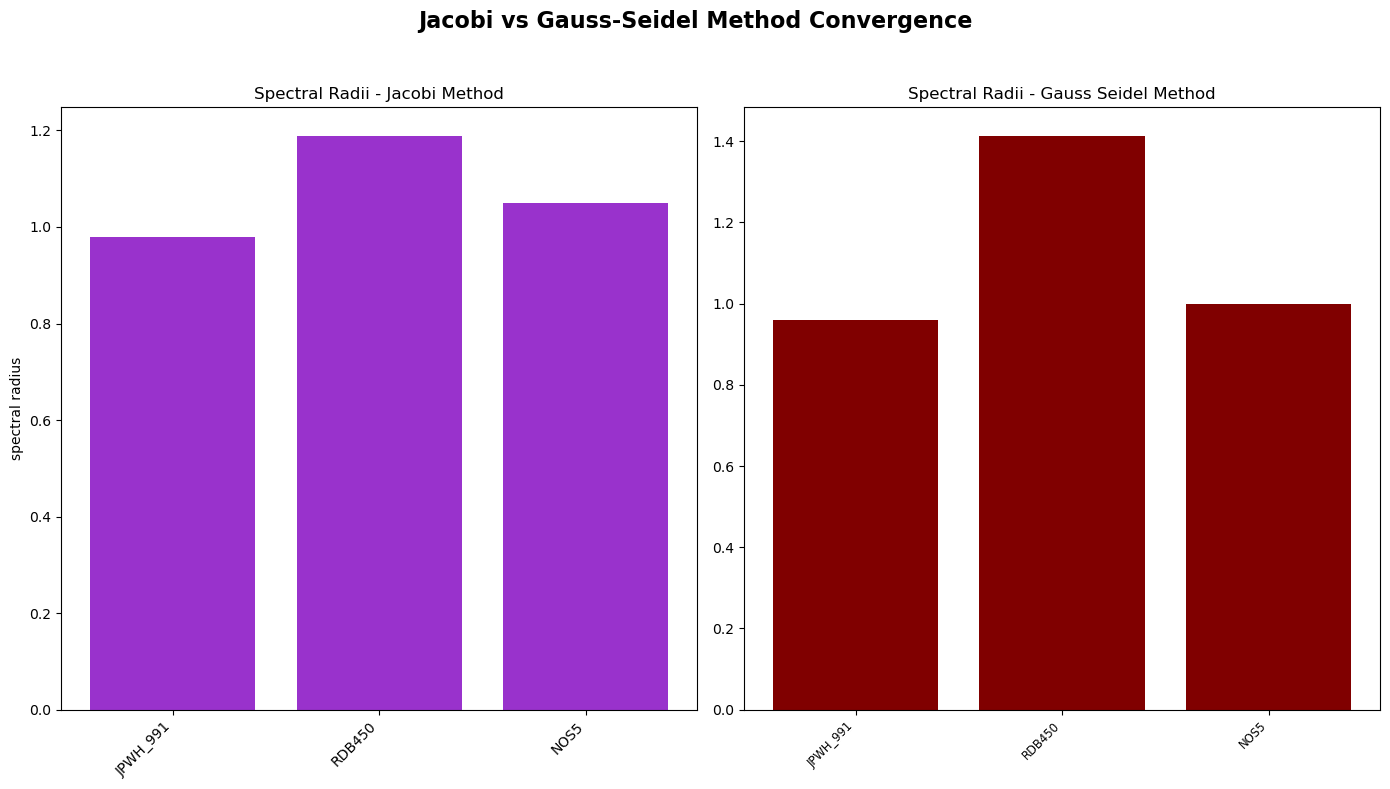

In [19]:
plot_radii((spectral_radii_jac, spectral_radii_gs))

In [20]:
print(spectral_radii_jac)
print(spectral_radii_gs)

[0.9797219720778314, 1.1884795269019903, 1.0489472213896638]
[0.9599151145438944, 1.412483585865173, 0.9979035692323661]


In [21]:
import pandas as pd
spe_radii_df = pd.DataFrame(columns=matrix_names, index=['Jacobi', 'Gauss-Seidel'])
spe_radii_df.loc['Jacobi'] = spectral_radii_jac
spe_radii_df.loc['Gauss-Seidel'] = spectral_radii_gs
print(spe_radii_df)

              JPWH_991    RDB450      NOS5
Jacobi        0.979722   1.18848  1.048947
Gauss-Seidel  0.959915  1.412484  0.997904
